In [96]:
from glob import glob
from datetime import datetime
from pickle import load, dump
from os import remove, makedirs, listdir
from os.path import exists, join
import numpy as np
from skimage import io

from cv2 import resize, cvtColor, COLOR_BGR2GRAY, GaussianBlur, imwrite, IMWRITE_PNG_COMPRESSION, imread, IMREAD_UNCHANGED
from scipy.ndimage import median_filter

import matplotlib.pylab as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

def _display(images_):
    
    for img_ in images_:
        img_ = img_.astype(np.double)
        idx_= img_ == 0.
        img_[idx_] = np.nan
        plt.figure(figsize = (15,10))
        plt.imshow(img_/255.0)
        plt.axis('off')
        plt.show()    

def _crop(X_): 
    return X_[15:465, 95:545].copy()

In [136]:
# Load the images taken with 4 different exposition and append them together
def _get_visible(path, unix):
    images_ = []
    for ii in range(4): 
        name = '{}/{}VI{}.png'.format(path, unix, ii)
        img_ = imread(name).astype('float32')
        images_.append(img_)  
    return images_

# Load the images taken with 4 different exposition and append them together
def _get_infrared(path, unix):
    name = '{}/{}IR.png'.format(path, unix)
    return io.imread(name).astype('float32')

path_in = r'/Users/Guille/Desktop/girasol_project/images_samples'
unix = '1523824125'

dim_ = (480, 640)  
c_   = (dim_[0] / 2, dim_[1] / 2)

X_, Y_ = np.meshgrid(np.linspace(0, dim_[1] - 1, dim_[1]), np.linspace(0, dim_[0] - 1, dim_[0]))

# Load the Images
images_ = _get_visible(path_in, unix)

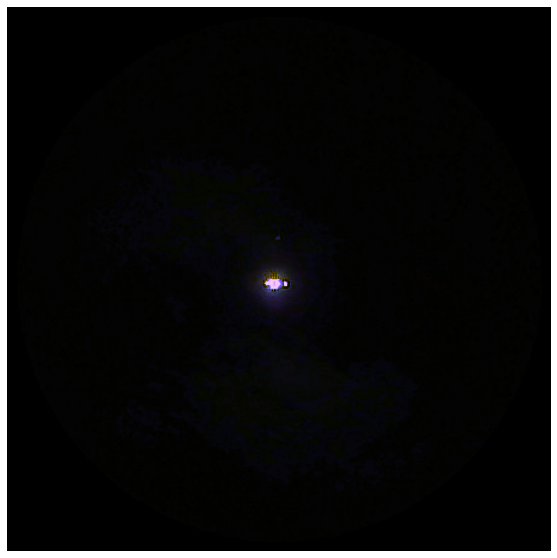

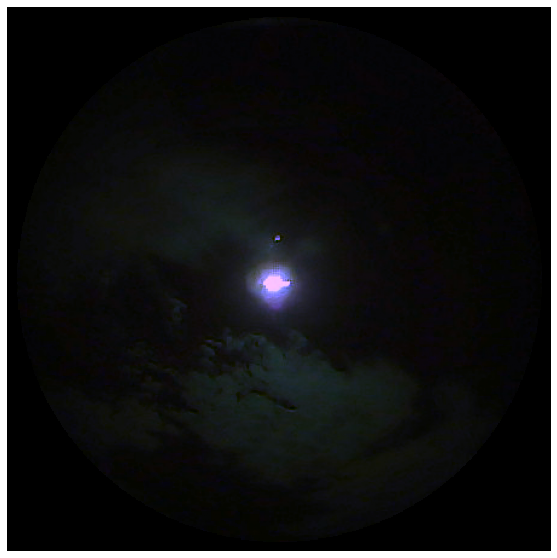

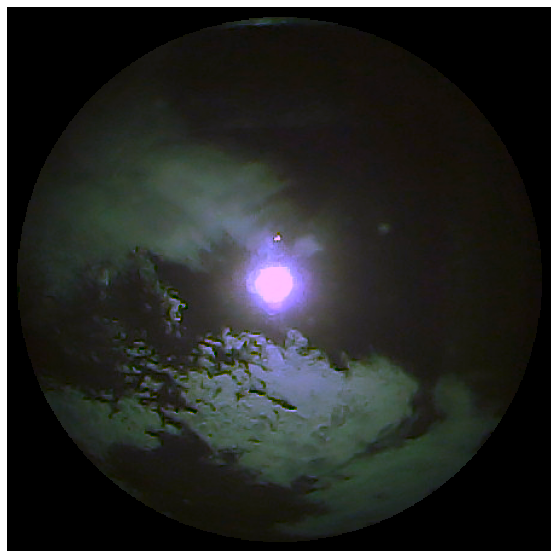

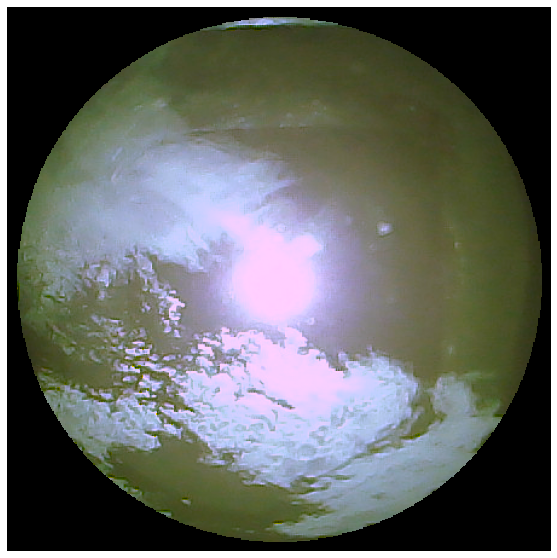

In [137]:
# FUNCTION TO ADJUNST THE WHITE BALANCE AND TRANSFOR TO GRAY SCALE THE CORRECTED IMAGES
def _white_balance(images_, idx_):
    images_wb_ = []
    for img_ in images_:
        
        img_ = img_.astype('uint16')

        # Separte RGB color components and calculate their average
        mRed   = np.mean(img_[..., 0])
        mGreen = np.mean(img_[..., 1])
        mBlue  = np.mean(img_[..., 2])

        # Estimate a costant for white balance using gray image average as reference
        mGray = np.mean(cvtColor(img_, COLOR_BGR2GRAY))

        # Adjust each element in the RGB components with respect to the white balance constant
        img_[..., 0] = img_[..., 0] * (mGray / mRed)
        img_[..., 1] = img_[..., 1] * (mGray / mGreen)
        img_[..., 2] = img_[..., 2] * (mGray / mBlue)
        
        # Regularization
        img_[(img_ >= 255.)] = 255.
        img_[~idx_, :] = 0.
        images_wb_.append(img_[15:465, 95:545, :].astype('uint8'))
    return images_wb_

idx_ =  np.sqrt((X_ - c_[1])**2 + (Y_ - c_[0])**2) <= 217.5
images_wb_ = _white_balance(images_, idx_)
_display(images_wb_)

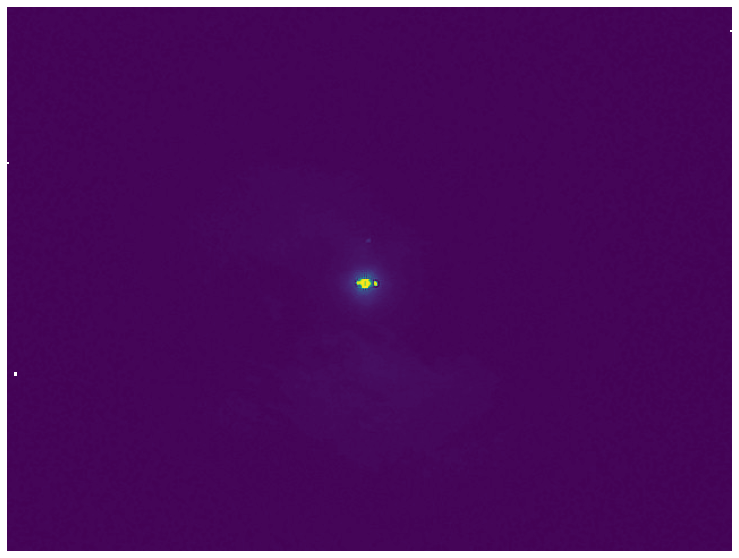

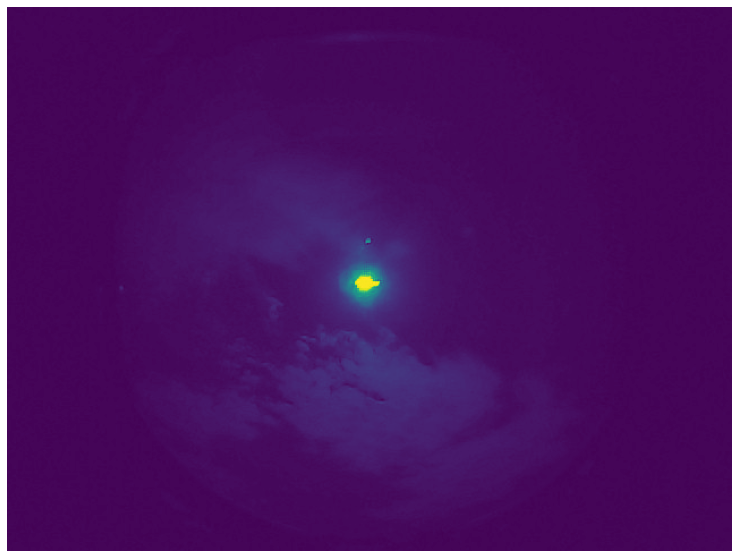

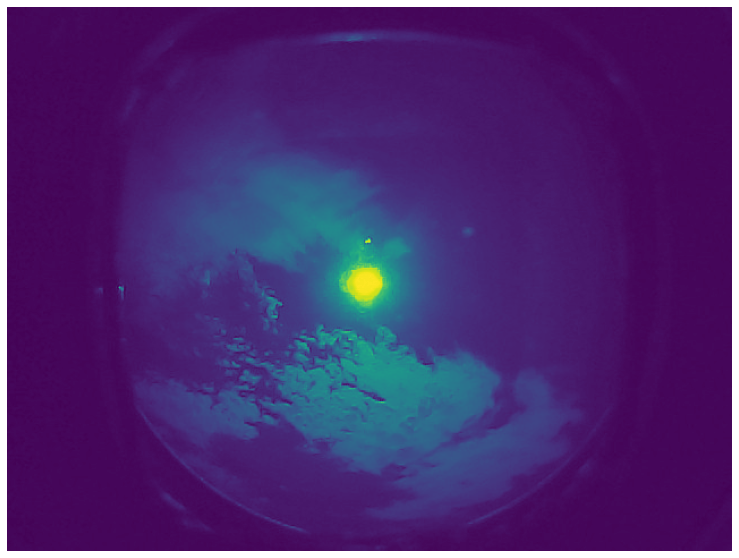

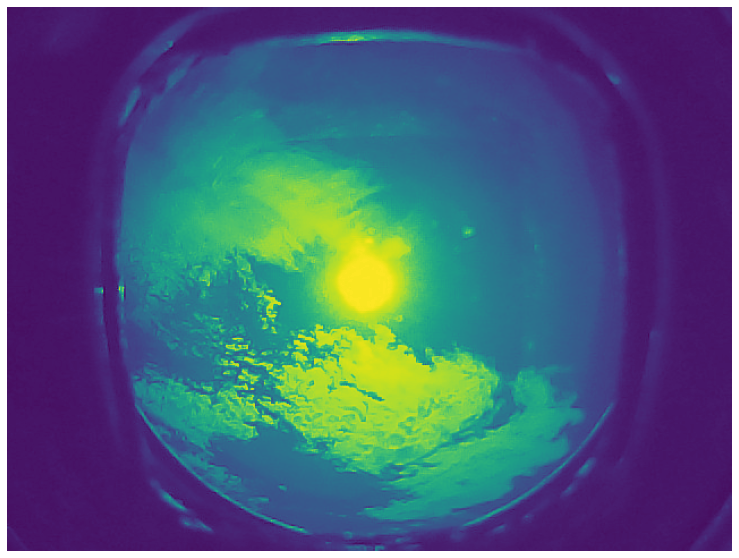

In [138]:
# FUNCTION TO CROP THE IMAGES TO THE RIGHT SIZE
def _reg_images(images_, lambda_ = 1e-3):
    images_reg_ = []

    for img_ in images_:
        if np.isnan(img_).any(): img_ = np.nan_to_num(img_) + lambda_
        images_reg_.append(img_)
        
    return images_reg_


def _color_gray(images_):
    images_gray = []
    
    for img_ in images_: images_gray.append(cvtColor(img_, COLOR_BGR2GRAY))

    return images_gray

images_reg_  = _reg_images(images_)
images_gray_ = _color_gray(images_reg_)
_display(images_gray_)

(480, 640)


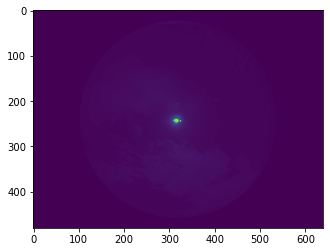

In [139]:
# FUNCTION TO APPLY THE MASK AND MERGE TOGETHER THE DIFFERENT EXPOSURES TIMES IMAGES
def _merge_images(I_, M_):

    # Defining variable weights for the model
    a_1 = 1.
    a_2 = a_1 * np.mean(I_[0] * M_[4][0]) / np.mean(I_[1] * M_[3][0])
    a_3 = a_2 * np.mean(I_[1] * M_[4][1]) / np.mean(I_[2] * M_[3][1])
    a_4 = a_3 * np.mean(I_[2] * M_[4][2]) / np.mean(I_[3] * M_[3][2])
    a_  = [a_1, a_2, a_3, a_4]

    # Definining equation and computing merged image
    X_4_ = (1 - M_[5][3]) * (I_[0] * a_[0] + I_[1] * a_[1] + I_[2] * a_[2] + I_[3] * a_[3]) / 4.
    X_3_ = M_[5][3] * (1 - M_[5][2]) * (I_[0] * a_[0] + I_[1] * a_[1] + I_[2] * a_[2]) / 3.
    X_2_ = M_[5][2] * (1 - M_[5][1]) * (I_[0] * a_[0] + I_[1] * a_[1]) / 2.
    X_1_ = M_[5][1] * I_[0] * a_[0]
    X_   = X_1_ + X_2_ + X_3_ + X_4_

    X_ = (X_ / 225.) * (2**16)
    
    X_[X_ > (2**16)] = 2**16
    X_[~idx_]        = 0.
    return X_.astype(np.uint16)

img_hdr_ = _merge_images(images_gray_, M_)
print(img_hdr_.shape)

plt.figure()
plt.imshow(img_hdr_)
plt.show()

<ipython-input-140-881e02e5b3d1>:2: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(_crop(img_hdr_)), cmap = 'inferno')


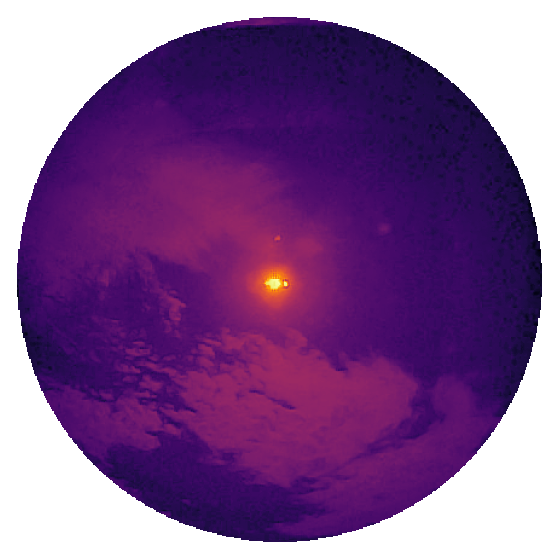

In [140]:
plt.figure(figsize = (15,10))
plt.imshow(np.log(_crop(img_hdr_)), cmap = 'inferno')
plt.axis('off')
plt.show()

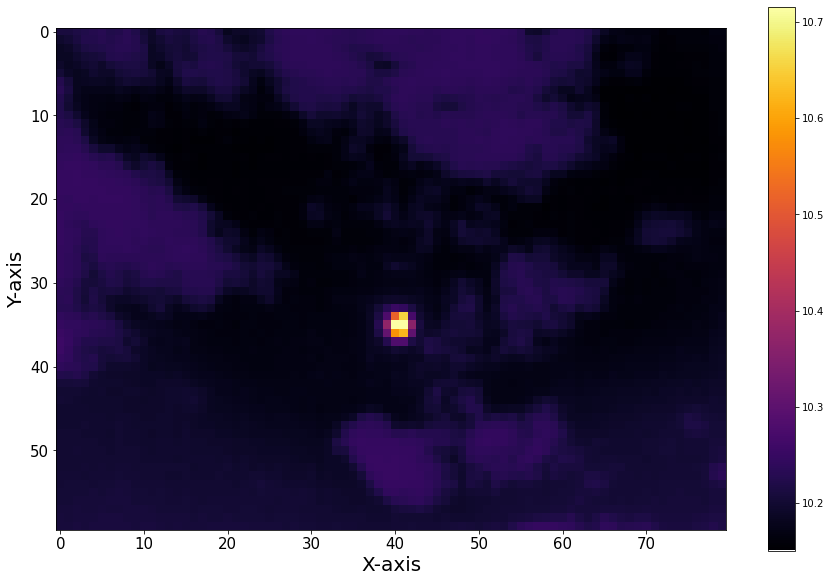

In [135]:
infrared_ = _get_infrared(path_in, unix)

plt.figure(figsize = (15, 10))
plt.imshow(np.log(infrared_), cmap = 'inferno')
#plt.title(r'UNIX: {} [s]'.format(unix), fontsize = 20)
plt.ylabel(r'Y-axis', fontsize = 20)
plt.xlabel(r'X-axis', fontsize = 20)
plt.yticks(np.arange(0., 60., 10), fontsize = 15)
plt.xticks(np.arange(0., 80., 10), fontsize = 15)
plt.colorbar()#.set_ticks([])
plt.show()  